In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

center_data = pd.read_csv('db/center_full_gestures_random_00.csv')
left_data = pd.read_csv('db/left_full_gestures_random_00.csv')
right_data = pd.read_csv('db/right_full_gestures_random_00.csv')
print(center_data.head())

      Timestamp  CH_1  CH_2  CH_3  CH_4  CH_5  CH_6  CH_7  CH_8 State
0  1.764005e+09     0     2     0     2     2    19    -3    -1  REST
1  1.764005e+09    -2    -2     0    -1    -3   -15    -1    -2  REST
2  1.764005e+09     0     0    -1    -1     3    16     0     0  REST
3  1.764005e+09    -1    -1    -1     0    -3   -14    -1     1  REST
4  1.764005e+09    -3     0     0    -2     0     8    -1    -1  REST


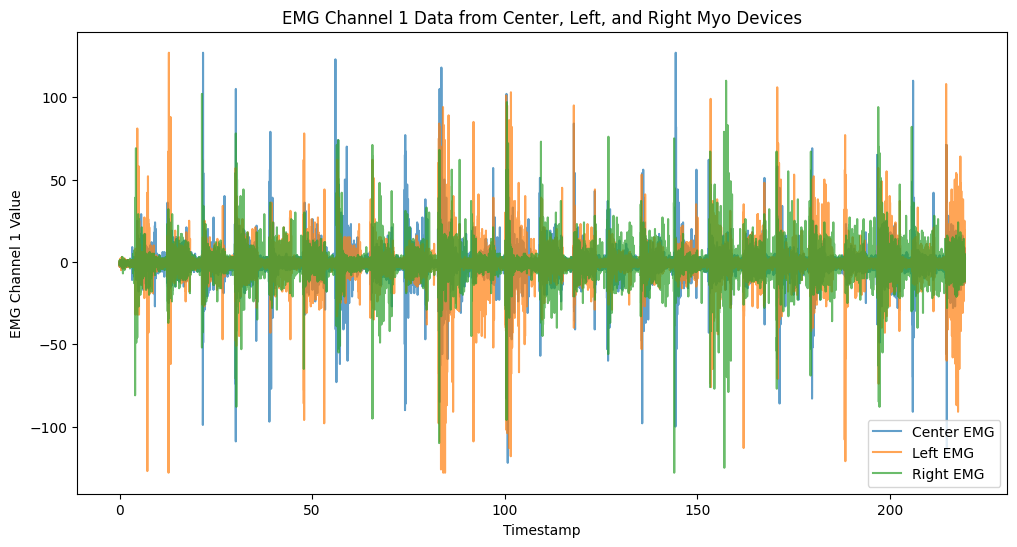

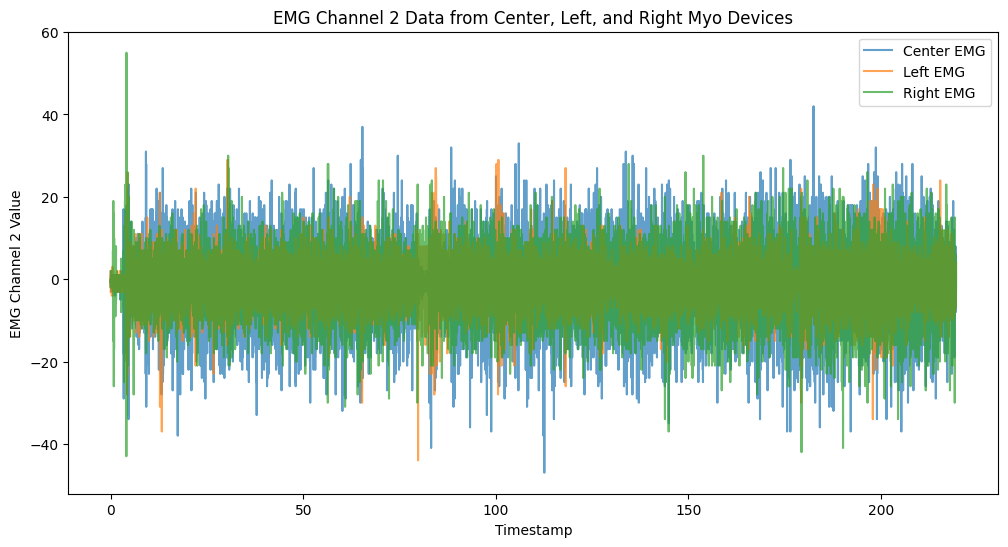

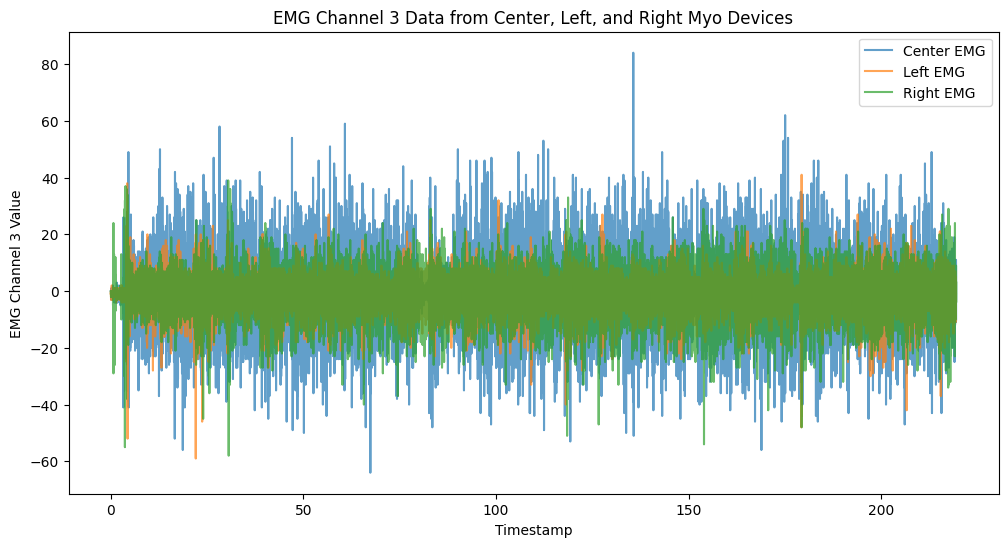

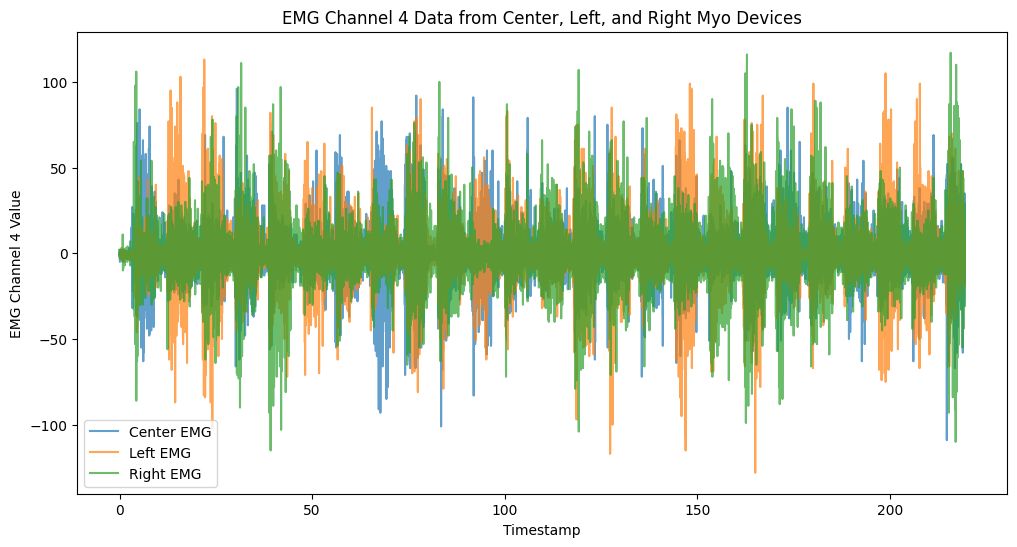

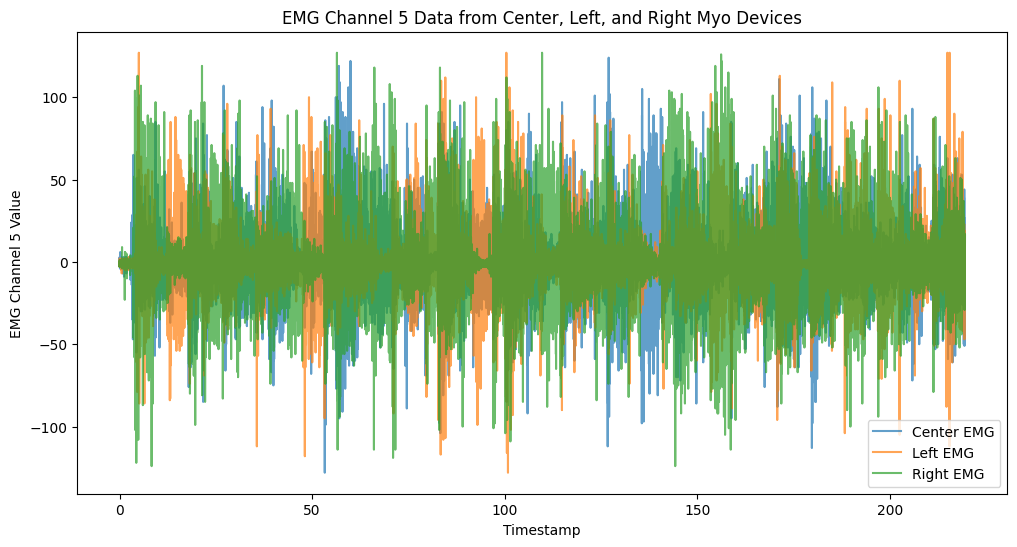

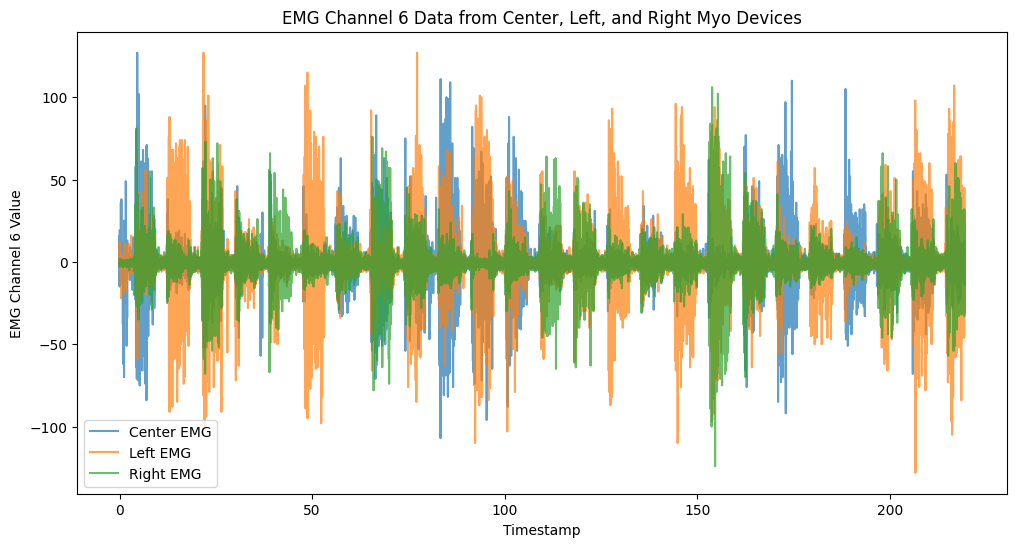

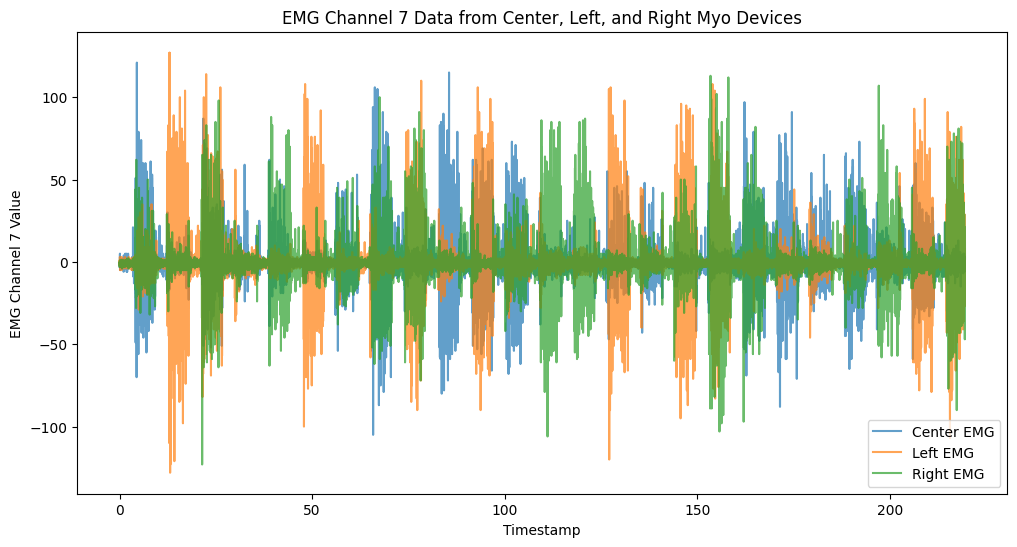

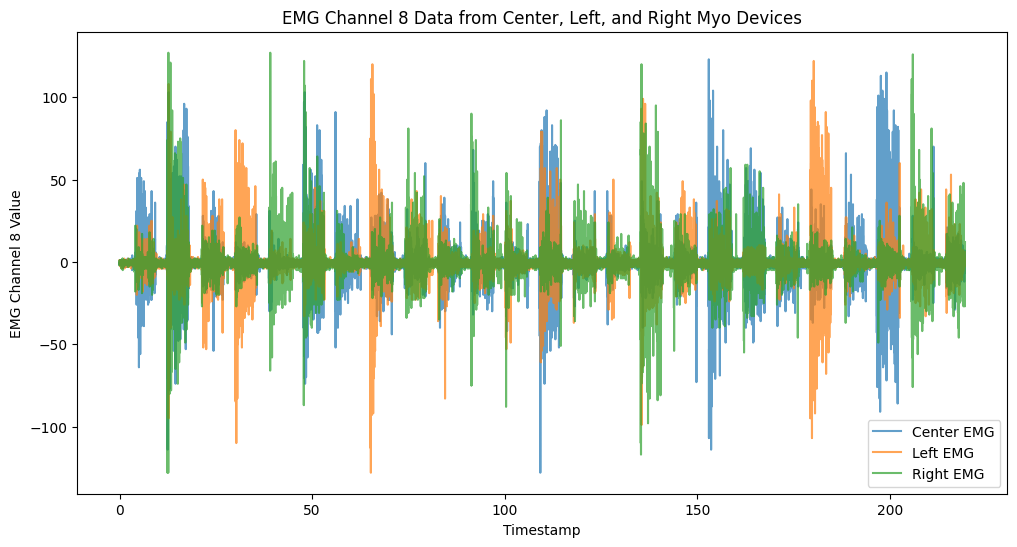

In [2]:
for i in range(1, 9):
    plt.figure(figsize=(12, 6))
    plt.plot(center_data['Timestamp']-center_data['Timestamp'][0], center_data[f'CH_{i}'], label='Center EMG', alpha=0.7)
    plt.plot(left_data['Timestamp']-left_data['Timestamp'][0], left_data[f'CH_{i}'], label='Left EMG', alpha=0.7)
    plt.plot(right_data['Timestamp']-right_data['Timestamp'][0], right_data[f'CH_{i}'], label='Right EMG', alpha=0.7)
    plt.xlabel('Timestamp')
    plt.ylabel(f'EMG Channel {i} Value')
    plt.title(f'EMG Channel {i} Data from Center, Left, and Right Myo Devices')
    plt.legend()
    plt.show()

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import kurtosis, skew
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder

# --- 1. Helper Math Functions ---
def zero_crossings(x): return ((x[:-1] * x[1:]) < 0).sum()
def slope_sign_changes(x): return np.sum((np.diff(np.sign(np.diff(x)))) != 0)
def waveform_length(x): return np.sum(np.abs(np.diff(x)))

# --- 2. Sliding Window Function with State Isolation ---
def extract_sliding_features(df, sensor_cols, window_size=15, step_size=1):
    """
    Applies sliding window only within contiguous state blocks.
    Prevents windows from mixing data between different states.
    """
    
    # Create unique ID for contiguous blocks (e.g., Rest_1, Move_1, Rest_2...)
    df['block_id'] = (df['State'] != df['State'].shift()).cumsum()
    
    all_features = []
    all_labels = []
    
    # Iterate through each contiguous block independently
    for block_id, group_data in df.groupby('block_id'):
        
        # Get the label for this specific block
        current_state = group_data['State'].iloc[0]
        
        # Extract sensor data as numpy array for speed
        sensor_values = group_data[sensor_cols].values
        
        # Check if block is large enough for at least one window
        n_samples = len(sensor_values)
        if n_samples < window_size:
            continue

        # SLIDING WINDOW LOOP
        # step_size=1 means every single sample (high overlap)
        for i in range(0, n_samples - window_size + 1, step_size):
            
            # Slice the window (strictly within this block)
            window = sensor_values[i : i + window_size]
            
            row_features = []
            
            # Calculate features for each channel in this window
            for ch_idx in range(window.shape[1]):
                x = window[:, ch_idx]
                
                # Calculate the 9 features
                feats = [
                    np.sqrt(np.mean(x**2)),         # RMS
                    np.mean(np.abs(x)),             # MAV
                    zero_crossings(x),              # ZC
                    slope_sign_changes(x),          # SSC
                    waveform_length(x),             # WL
                    np.var(x),                      # Variance
                    np.mean(x),                     # Mean
                    kurtosis(x) if np.std(x) > 0 else 0, # Kurtosis
                    skew(x) if np.std(x) > 0 else 0      # Skew
                ]
                
                # Handle NaNs
                feats = [0 if np.isnan(v) else v for v in feats]
                row_features.extend(feats)
            
            all_features.append(row_features)
            all_labels.append(current_state)
            
    # Convert to DataFrame
    X_df = pd.DataFrame(all_features)
    
    # Generate Column Names
    feat_suffixes = ['RMS','MAV','ZC','SSC','WL','VAR','MEAN','KURT','SKEW']
    col_names = [f'{ch}_{feat}' for ch in sensor_cols for feat in feat_suffixes]
    
    if len(X_df.columns) == len(col_names):
        X_df.columns = col_names
        
    return X_df, all_labels

# --- 3. Main Execution ---

datasets = [center_data, left_data, right_data]
sensor_columns = [f'CH_{i}' for i in range(1, 9)] 

# B. Process All Files
all_X_parts = []
all_y_parts = []

print("Extracting features (this may take a moment)...")
for i, data in enumerate(datasets):
    print(f"  - Processing file {i+1}/3")
    
    # CALL FUNCTION: Window Size = 15, Step = 1 (Maximum overlap)
    # Hint: Increase step_size to 5 or 10 to make it run faster if dataset is huge
    X_part, y_part = extract_sliding_features(data, sensor_columns, window_size=15, step_size=1)
    
    all_X_parts.append(X_part)
    all_y_parts.extend(y_part)

# C. Combine
final_X = pd.concat(all_X_parts, ignore_index=True)
final_y_raw = all_y_parts

print(f"Total Windows Extracted: {len(final_X)}")

# D. Encode Labels
le = LabelEncoder()
final_y = le.fit_transform(final_y_raw)

# E. Feature Selection
print("Selecting Best Features...")
selector = SelectKBest(score_func=f_classif, k=10)
X_selected = selector.fit_transform(final_X, final_y)
selected_cols = final_X.columns[selector.get_support()]

print("\nTop 10 Selected Features:")
print(selected_cols.tolist())

Extracting features (this may take a moment)...
  - Processing file 1/3
  - Processing file 2/3
  - Processing file 3/3
Total Windows Extracted: 38193
Selecting Best Features...

Top 10 Selected Features:
['CH_6_RMS', 'CH_6_MAV', 'CH_6_WL', 'CH_7_RMS', 'CH_7_MAV', 'CH_7_WL', 'CH_7_VAR', 'CH_8_RMS', 'CH_8_MAV', 'CH_8_WL']


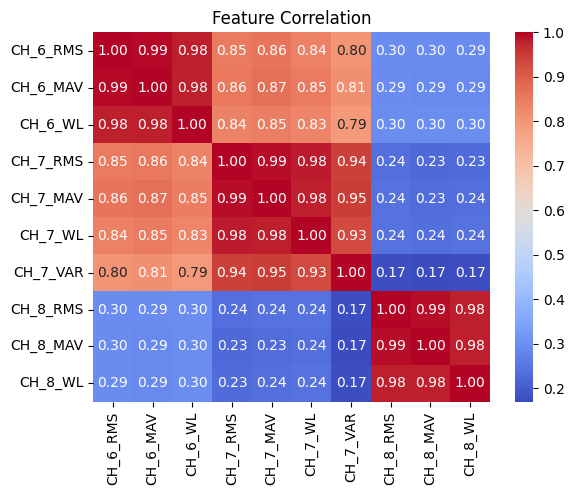

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = pd.DataFrame(X_selected, columns=selected_cols).corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation")
plt.show()

In [5]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay


X_train, X_test, y_train, y_test = train_test_split(final_X, final_y, test_size=0.2, random_state=42, stratify=final_y)

average=np.array([0])
preci=np.array([0])
senci=np.array([0])
bst_est=[]

kf = KFold(n_splits=5, shuffle=True, random_state=7)

def training_and_testing(estimator, param_grid, X_train, y_train, X_test, y_test):
    grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=kf, scoring='accuracy', verbose=2)

    # Perform the grid search
    grid_search.fit(X_train, y_train)

    # Best parameters and best score
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # Calculate and print all final metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    sensitivity = recall_score(y_test, y_pred, average='weighted') # Sensitivity is the same as recall

    print(f"Final Test Accuracy: {accuracy:.2f}")
    print(f"Final Test Precision: {precision:.2f}")
    print(f"Final Test Sensitivity (Recall): {sensitivity:.2f}")

    # Display the final confusion matrix
    print("\nFinal Confusion Matrix (on test data):")
    mat_con = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=mat_con)
    disp.plot()
    plt.show()
    return accuracy, precision, sensitivity, grid_search

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ....................metric=minkowski, n_neighbors=2; total time=   2.2s
[CV] END ....................metric=minkowski, n_neighbors=2; total time=   0.1s
[CV] END ....................metric=minkowski, n_neighbors=2; total time=   0.1s
[CV] END ....................metric=minkowski, n_neighbors=2; total time=   0.1s
[CV] END ....................metric=minkowski, n_neighbors=2; total time=   0.1s
[CV] END ....................metric=minkowski, n_neighbors=4; total time=   0.1s
[CV] END ....................metric=minkowski, n_neighbors=4; total time=   0.1s
[CV] END ....................metric=minkowski, n_neighbors=4; total time=   0.1s
[CV] END ....................metric=minkowski, n_neighbors=4; total time=   0.1s
[CV] END ....................metric=minkowski, n_neighbors=4; total time=   0.1s
[CV] END ....................metric=minkowski, n_neighbors=6; total time=   0.1s
[CV] END ....................metric=minkowski, n

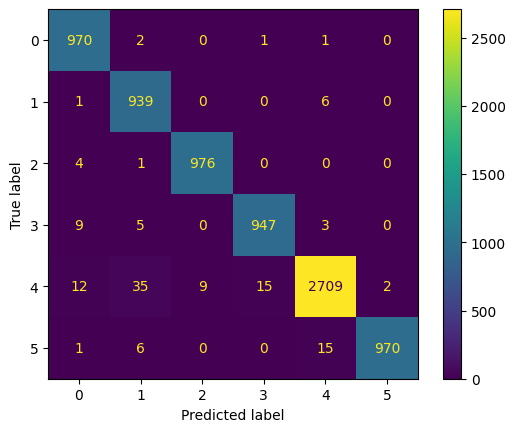

Accuracy:  0.9832438800890169
Precision:  0.9835378620806896
Sensitivity:  0.9832438800890169


In [6]:
from sklearn.neighbors import KNeighborsClassifier
# Define the model and parameters to tune
knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [2, 4, 6, 8],  # You can extend this list based on your dataset
    #'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'chebyshev', 'euclidean', 'manhattan']
}

accuracy, precision, sensitivity, grid_search = training_and_testing(knn, param_grid, X_train, y_train, X_test, y_test)
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Sensitivity: ", sensitivity)
average = np.vstack((average,accuracy))
preci=np.vstack((preci,precision))
senci=np.vstack((senci,sensitivity))
bst_est.append(grid_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END ..................................var_smoothing=1.0; total time=   0.0s
[CV] END ..................................var_smoothing=1.0; total time=   0.0s
[CV] END ..................................var_smoothing=1.0; total time=   0.0s
[CV] END ..................................var_smoothing=1.0; total time=   0.0s
[CV] END ..................................var_smoothing=1.0; total time=   0.0s
[CV] END ...................var_smoothing=0.8111308307896871; total time=   0.0s
[CV] END ...................var_smoothing=0.8111308307896871; total time=   0.0s
[CV] END ...................var_smoothing=0.8111308307896871; total time=   0.0s
[CV] END ...................var_smoothing=0.8111308307896871; total time=   0.0s
[CV] END ...................var_smoothing=0.8111308307896871; total time=   0.0s
[CV] END ....................var_smoothing=0.657933224657568; total time=   0.0s
[CV] END ....................var_smoothing=0.6

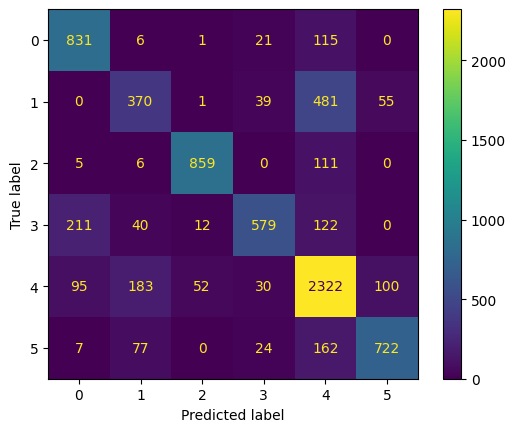

Accuracy:  0.7439455426102893
Precision:  0.7462486827798471
Sensitivity:  0.7439455426102893


In [7]:
from sklearn.naive_bayes import GaussianNB
# Define the model and parameters to tune
gnb = GaussianNB()
param_grid = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

accuracy, precision, sensitivity, grid_search = training_and_testing(gnb, param_grid, X_train, y_train, X_test, y_test)
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Sensitivity: ", sensitivity)
average = np.vstack((average,accuracy))
preci=np.vstack((preci,precision))
senci=np.vstack((senci,sensitivity))
bst_est.append(grid_search.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END ...............................C=0.0001, penalty=l1; total time=   0.0s
[CV] END ...............................C=0.0001, penalty=l1; total time=   0.0s
[CV] END ...............................C=0.0001, penalty=l1; total time=   0.0s
[CV] END ...............................C=0.0001, penalty=l1; total time=   0.0s
[CV] END ...............................C=0.0001, penalty=l1; total time=   0.0s


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...............................C=0.0001, penalty=l2; total time= 1.4min
[CV] END ...............................C=0.0001, penalty=l2; total time=  53.3s
[CV] END ...............................C=0.0001, penalty=l2; total time=  52.5s


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...............................C=0.0001, penalty=l2; total time= 1.2min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...............................C=0.0001, penalty=l2; total time= 1.2min
[CV] END ...............C=0.00026366508987303583, penalty=l1; total time=   0.0s
[CV] END ...............C=0.00026366508987303583, penalty=l1; total time=   0.0s
[CV] END ...............C=0.00026366508987303583, penalty=l1; total time=   0.0s
[CV] END ...............C=0.00026366508987303583, penalty=l1; total time=   0.0s
[CV] END ...............C=0.00026366508987303583, penalty=l1; total time=   0.0s


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...............C=0.00026366508987303583, penalty=l2; total time= 1.3min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...............C=0.00026366508987303583, penalty=l2; total time= 1.4min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...............C=0.00026366508987303583, penalty=l2; total time= 1.4min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...............C=0.00026366508987303583, penalty=l2; total time= 1.4min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...............C=0.00026366508987303583, penalty=l2; total time= 1.4min
[CV] END ................C=0.0006951927961775605, penalty=l1; total time=   0.0s
[CV] END ................C=0.0006951927961775605, penalty=l1; total time=   0.0s
[CV] END ................C=0.0006951927961775605, penalty=l1; total time=   0.0s
[CV] END ................C=0.0006951927961775605, penalty=l1; total time=   0.0s
[CV] END ................C=0.0006951927961775605, penalty=l1; total time=   0.0s


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ................C=0.0006951927961775605, penalty=l2; total time= 1.4min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ................C=0.0006951927961775605, penalty=l2; total time= 1.4min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ................C=0.0006951927961775605, penalty=l2; total time= 1.4min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ................C=0.0006951927961775605, penalty=l2; total time= 1.4min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ................C=0.0006951927961775605, penalty=l2; total time= 1.4min
[CV] END ................C=0.0018329807108324356, penalty=l1; total time=   0.0s
[CV] END ................C=0.0018329807108324356, penalty=l1; total time=   0.0s
[CV] END ................C=0.0018329807108324356, penalty=l1; total time=   0.0s
[CV] END ................C=0.0018329807108324356, penalty=l1; total time=   0.0s
[CV] END ................C=0.0018329807108324356, penalty=l1; total time=   0.0s


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ................C=0.0018329807108324356, penalty=l2; total time= 1.4min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ................C=0.0018329807108324356, penalty=l2; total time= 1.4min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ................C=0.0018329807108324356, penalty=l2; total time= 1.5min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ................C=0.0018329807108324356, penalty=l2; total time= 1.4min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ................C=0.0018329807108324356, penalty=l2; total time= 1.4min
[CV] END .................C=0.004832930238571752, penalty=l1; total time=   0.0s
[CV] END .................C=0.004832930238571752, penalty=l1; total time=   0.0s
[CV] END .................C=0.004832930238571752, penalty=l1; total time=   0.0s
[CV] END .................C=0.004832930238571752, penalty=l1; total time=   0.0s
[CV] END .................C=0.004832930238571752, penalty=l1; total time=   0.0s


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .................C=0.004832930238571752, penalty=l2; total time= 1.4min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .................C=0.004832930238571752, penalty=l2; total time= 1.4min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .................C=0.004832930238571752, penalty=l2; total time= 1.4min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .................C=0.004832930238571752, penalty=l2; total time= 1.3min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .................C=0.004832930238571752, penalty=l2; total time= 1.2min
[CV] END .................C=0.012742749857031334, penalty=l1; total time=   0.0s
[CV] END .................C=0.012742749857031334, penalty=l1; total time=   0.0s
[CV] END .................C=0.012742749857031334, penalty=l1; total time=   0.0s
[CV] END .................C=0.012742749857031334, penalty=l1; total time=   0.0s
[CV] END .................C=0.012742749857031334, penalty=l1; total time=   0.0s


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .................C=0.012742749857031334, penalty=l2; total time= 1.2min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .................C=0.012742749857031334, penalty=l2; total time= 1.3min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .................C=0.012742749857031334, penalty=l2; total time= 1.4min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .................C=0.012742749857031334, penalty=l2; total time= 1.4min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .................C=0.012742749857031334, penalty=l2; total time= 1.4min
[CV] END ..................C=0.03359818286283781, penalty=l1; total time=   0.0s
[CV] END ..................C=0.03359818286283781, penalty=l1; total time=   0.0s
[CV] END ..................C=0.03359818286283781, penalty=l1; total time=   0.0s
[CV] END ..................C=0.03359818286283781, penalty=l1; total time=   0.0s
[CV] END ..................C=0.03359818286283781, penalty=l1; total time=   0.0s


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..................C=0.03359818286283781, penalty=l2; total time= 1.2min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..................C=0.03359818286283781, penalty=l2; total time= 1.1min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..................C=0.03359818286283781, penalty=l2; total time= 1.1min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..................C=0.03359818286283781, penalty=l2; total time= 1.2min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..................C=0.03359818286283781, penalty=l2; total time= 1.1min
[CV] END ..................C=0.08858667904100823, penalty=l1; total time=   0.0s
[CV] END ..................C=0.08858667904100823, penalty=l1; total time=   0.0s
[CV] END ..................C=0.08858667904100823, penalty=l1; total time=   0.0s
[CV] END ..................C=0.08858667904100823, penalty=l1; total time=   0.0s
[CV] END ..................C=0.08858667904100823, penalty=l1; total time=   0.0s


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..................C=0.08858667904100823, penalty=l2; total time= 1.1min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..................C=0.08858667904100823, penalty=l2; total time= 1.1min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..................C=0.08858667904100823, penalty=l2; total time= 1.0min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..................C=0.08858667904100823, penalty=l2; total time= 1.1min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..................C=0.08858667904100823, penalty=l2; total time= 1.2min
[CV] END ..................C=0.23357214690901212, penalty=l1; total time=   0.0s
[CV] END ..................C=0.23357214690901212, penalty=l1; total time=   0.0s
[CV] END ..................C=0.23357214690901212, penalty=l1; total time=   0.0s
[CV] END ..................C=0.23357214690901212, penalty=l1; total time=   0.0s
[CV] END ..................C=0.23357214690901212, penalty=l1; total time=   0.0s


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..................C=0.23357214690901212, penalty=l2; total time= 1.2min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..................C=0.23357214690901212, penalty=l2; total time= 1.2min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..................C=0.23357214690901212, penalty=l2; total time= 1.2min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..................C=0.23357214690901212, penalty=l2; total time= 1.2min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..................C=0.23357214690901212, penalty=l2; total time= 1.2min
[CV] END ....................C=0.615848211066026, penalty=l1; total time=   0.0s
[CV] END ....................C=0.615848211066026, penalty=l1; total time=   0.0s
[CV] END ....................C=0.615848211066026, penalty=l1; total time=   0.0s
[CV] END ....................C=0.615848211066026, penalty=l1; total time=   0.0s
[CV] END ....................C=0.615848211066026, penalty=l1; total time=   0.0s


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=0.615848211066026, penalty=l2; total time= 1.2min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=0.615848211066026, penalty=l2; total time= 1.2min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=0.615848211066026, penalty=l2; total time= 1.2min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=0.615848211066026, penalty=l2; total time= 1.2min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=0.615848211066026, penalty=l2; total time= 1.2min
[CV] END ....................C=1.623776739188721, penalty=l1; total time=   0.0s
[CV] END ....................C=1.623776739188721, penalty=l1; total time=   0.0s
[CV] END ....................C=1.623776739188721, penalty=l1; total time=   0.0s
[CV] END ....................C=1.623776739188721, penalty=l1; total time=   0.0s
[CV] END ....................C=1.623776739188721, penalty=l1; total time=   0.0s


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=1.623776739188721, penalty=l2; total time= 1.3min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=1.623776739188721, penalty=l2; total time= 1.3min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=1.623776739188721, penalty=l2; total time= 1.3min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=1.623776739188721, penalty=l2; total time= 1.3min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=1.623776739188721, penalty=l2; total time= 1.2min
[CV] END ....................C=4.281332398719396, penalty=l1; total time=   0.0s
[CV] END ....................C=4.281332398719396, penalty=l1; total time=   0.0s
[CV] END ....................C=4.281332398719396, penalty=l1; total time=   0.0s
[CV] END ....................C=4.281332398719396, penalty=l1; total time=   0.0s
[CV] END ....................C=4.281332398719396, penalty=l1; total time=   0.0s


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=4.281332398719396, penalty=l2; total time= 1.2min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=4.281332398719396, penalty=l2; total time= 1.2min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=4.281332398719396, penalty=l2; total time= 1.2min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=4.281332398719396, penalty=l2; total time= 1.2min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=4.281332398719396, penalty=l2; total time= 1.2min
[CV] END ...................C=11.288378916846883, penalty=l1; total time=   0.0s
[CV] END ...................C=11.288378916846883, penalty=l1; total time=   0.0s
[CV] END ...................C=11.288378916846883, penalty=l1; total time=   0.0s
[CV] END ...................C=11.288378916846883, penalty=l1; total time=   0.0s
[CV] END ...................C=11.288378916846883, penalty=l1; total time=   0.0s


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...................C=11.288378916846883, penalty=l2; total time= 1.2min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...................C=11.288378916846883, penalty=l2; total time= 1.2min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...................C=11.288378916846883, penalty=l2; total time= 1.2min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...................C=11.288378916846883, penalty=l2; total time= 1.2min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...................C=11.288378916846883, penalty=l2; total time= 1.2min
[CV] END ...................C=29.763514416313132, penalty=l1; total time=   0.0s
[CV] END ...................C=29.763514416313132, penalty=l1; total time=   0.0s
[CV] END ...................C=29.763514416313132, penalty=l1; total time=   0.0s
[CV] END ...................C=29.763514416313132, penalty=l1; total time=   0.0s
[CV] END ...................C=29.763514416313132, penalty=l1; total time=   0.0s


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...................C=29.763514416313132, penalty=l2; total time= 1.2min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...................C=29.763514416313132, penalty=l2; total time= 1.2min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...................C=29.763514416313132, penalty=l2; total time= 1.2min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...................C=29.763514416313132, penalty=l2; total time= 1.2min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...................C=29.763514416313132, penalty=l2; total time= 1.2min
[CV] END ....................C=78.47599703514607, penalty=l1; total time=   0.0s
[CV] END ....................C=78.47599703514607, penalty=l1; total time=   0.0s
[CV] END ....................C=78.47599703514607, penalty=l1; total time=   0.0s
[CV] END ....................C=78.47599703514607, penalty=l1; total time=   0.0s
[CV] END ....................C=78.47599703514607, penalty=l1; total time=   0.0s


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=78.47599703514607, penalty=l2; total time= 1.2min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=78.47599703514607, penalty=l2; total time= 1.2min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=78.47599703514607, penalty=l2; total time= 1.2min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=78.47599703514607, penalty=l2; total time= 1.2min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=78.47599703514607, penalty=l2; total time= 1.2min
[CV] END .....................C=206.913808111479, penalty=l1; total time=   0.0s
[CV] END .....................C=206.913808111479, penalty=l1; total time=   0.0s
[CV] END .....................C=206.913808111479, penalty=l1; total time=   0.0s
[CV] END .....................C=206.913808111479, penalty=l1; total time=   0.0s
[CV] END .....................C=206.913808111479, penalty=l1; total time=   0.0s


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .....................C=206.913808111479, penalty=l2; total time= 1.2min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .....................C=206.913808111479, penalty=l2; total time= 1.2min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .....................C=206.913808111479, penalty=l2; total time= 1.2min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .....................C=206.913808111479, penalty=l2; total time= 1.2min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .....................C=206.913808111479, penalty=l2; total time= 1.3min
[CV] END ....................C=545.5594781168514, penalty=l1; total time=   0.0s
[CV] END ....................C=545.5594781168514, penalty=l1; total time=   0.0s
[CV] END ....................C=545.5594781168514, penalty=l1; total time=   0.0s
[CV] END ....................C=545.5594781168514, penalty=l1; total time=   0.0s
[CV] END ....................C=545.5594781168514, penalty=l1; total time=   0.0s


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=545.5594781168514, penalty=l2; total time= 1.2min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=545.5594781168514, penalty=l2; total time= 1.2min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=545.5594781168514, penalty=l2; total time= 1.2min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=545.5594781168514, penalty=l2; total time= 1.3min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=545.5594781168514, penalty=l2; total time= 1.2min
[CV] END .....................C=1438.44988828766, penalty=l1; total time=   0.0s
[CV] END .....................C=1438.44988828766, penalty=l1; total time=   0.0s
[CV] END .....................C=1438.44988828766, penalty=l1; total time=   0.0s
[CV] END .....................C=1438.44988828766, penalty=l1; total time=   0.0s
[CV] END .....................C=1438.44988828766, penalty=l1; total time=   0.0s


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .....................C=1438.44988828766, penalty=l2; total time= 1.2min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .....................C=1438.44988828766, penalty=l2; total time= 1.2min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .....................C=1438.44988828766, penalty=l2; total time= 1.2min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .....................C=1438.44988828766, penalty=l2; total time= 1.2min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .....................C=1438.44988828766, penalty=l2; total time= 1.2min
[CV] END ....................C=3792.690190732246, penalty=l1; total time=   0.0s
[CV] END ....................C=3792.690190732246, penalty=l1; total time=   0.0s
[CV] END ....................C=3792.690190732246, penalty=l1; total time=   0.0s
[CV] END ....................C=3792.690190732246, penalty=l1; total time=   0.0s
[CV] END ....................C=3792.690190732246, penalty=l1; total time=   0.0s


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=3792.690190732246, penalty=l2; total time= 1.2min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=3792.690190732246, penalty=l2; total time= 1.2min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=3792.690190732246, penalty=l2; total time= 1.2min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=3792.690190732246, penalty=l2; total time= 1.3min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=3792.690190732246, penalty=l2; total time= 1.2min
[CV] END ..............................C=10000.0, penalty=l1; total time=   0.0s
[CV] END ..............................C=10000.0, penalty=l1; total time=   0.0s
[CV] END ..............................C=10000.0, penalty=l1; total time=   0.0s
[CV] END ..............................C=10000.0, penalty=l1; total time=   0.0s
[CV] END ..............................C=10000.0, penalty=l1; total time=   0.0s


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..............................C=10000.0, penalty=l2; total time= 1.2min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..............................C=10000.0, penalty=l2; total time= 1.2min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..............................C=10000.0, penalty=l2; total time= 1.2min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..............................C=10000.0, penalty=l2; total time= 1.2min


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
100 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more det

[CV] END ..............................C=10000.0, penalty=l2; total time= 1.3min
Best parameters: {'C': np.float64(0.03359818286283781), 'penalty': 'l2'}
Best cross-validation score: 0.82
Final Test Accuracy: 0.82
Final Test Precision: 0.82
Final Test Sensitivity (Recall): 0.82

Final Confusion Matrix (on test data):


c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


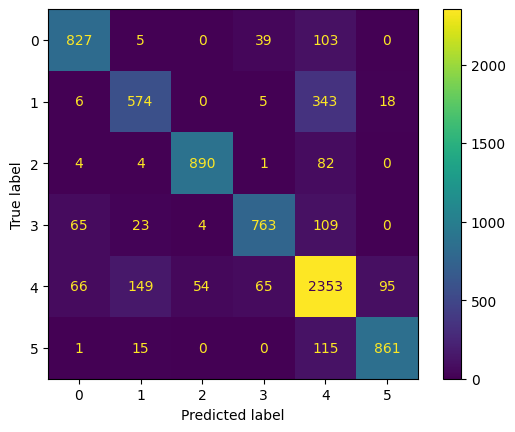

Accuracy:  0.8205262468909543
Precision:  0.8227675310324424
Sensitivity:  0.8205262468909543


In [8]:
from sklearn.linear_model import LogisticRegression
# Define the model and parameters to tune
log_reg = LogisticRegression(max_iter=10000)  # Increasing max_iter for convergence with larger datasets or more complex models
param_grid = {
    'C': np.logspace(-4, 4, 20),  # Explore a range of regularization strengths
    'penalty': ['l1', 'l2']#,  # 'l1', 'l2', 'elasticnet' might be options, depending on the solver
    #'solver': ['lbfgs', 'liblinear']  # Suitable solvers for small to medium datasets
}

accuracy, precision, sensitivity, grid_search = training_and_testing(log_reg, param_grid, X_train, y_train, X_test, y_test)
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Sensitivity: ", sensitivity)
average = np.vstack((average,accuracy))
preci=np.vstack((preci,precision))
senci=np.vstack((senci,sensitivity))
bst_est.append(grid_search.best_params_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=2; total time=   0.4s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=2; total time=   0.4s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=2; total time=   0.4s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=2; total time=   0.3s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=2; total time=   0.4s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=4; total time=   0.4s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=4; total time=   0.4s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=4; total time=   0.4s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=4; total time=   0.4s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=4; total time=   0.4s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=6; total time=   0.4s
[CV] END max_depth=5, min_samples_le

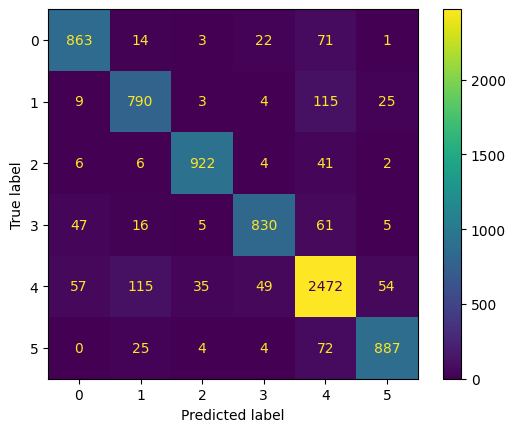

Accuracy:  0.8854562115460138
Precision:  0.8860141569800625
Sensitivity:  0.8854562115460138


In [9]:
from sklearn.tree import DecisionTreeClassifier
# Define the model and parameters to tune
decision_tree = DecisionTreeClassifier()
param_grid = {
    'max_depth': [5, 10, 15, 20, 25, 30],  # None means no limit
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [2, 4, 6, 8]
}

accuracy, precision, sensitivity, grid_search = training_and_testing(decision_tree, param_grid, X_train, y_train, X_test, y_test)
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Sensitivity: ", sensitivity)
average = np.vstack((average,accuracy))
preci=np.vstack((preci,precision))
senci=np.vstack((senci,sensitivity))
bst_est.append(grid_search.best_params_)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   7.0s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   6.9s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   6.8s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   7.0s
[CV] END max_depth=5, min_samples_lea

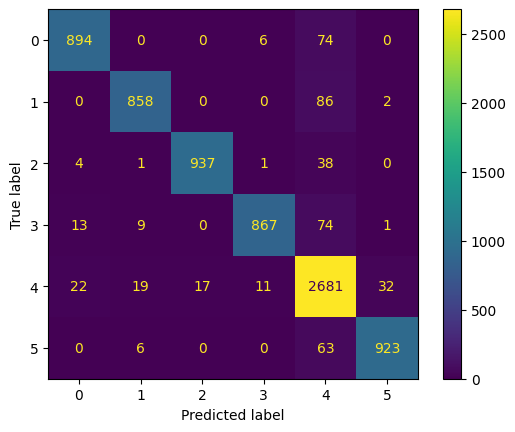

Accuracy:  0.9372954575206179
Precision:  0.9397657026286346
Sensitivity:  0.9372954575206179


In [10]:
from sklearn.ensemble import RandomForestClassifier
# Define the model and parameters to tune
random_forest = RandomForestClassifier()
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [5, 10, 15, 20],  # Maximum depth of the tree
    'min_samples_split': [2, 4, 6, 8],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [2, 4, 6, 8]  # Minimum number of samples required at each leaf node
}

accuracy, precision, sensitivity, grid_search = training_and_testing(random_forest, param_grid, X_train, y_train, X_test, y_test)
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Sensitivity: ", sensitivity)
average = np.vstack((average,accuracy))
preci=np.vstack((preci,precision))
senci=np.vstack((senci,sensitivity))
bst_est.append(grid_search.best_params_)

c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 16 is smaller than n_iter=50. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.779 total time=  14.8s
[CV 2/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.781 total time=  14.3s
[CV 3/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.779 total time=  14.4s
[CV 4/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.774 total time=  14.4s
[CV 5/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.787 total time=  15.2s
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.369 total time= 1.6min
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.373 total time= 1.6min
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.364 total time= 1.6min
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.362 total time= 1.7min
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.353 total time= 1.6min
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.369 total time= 1.6min
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;

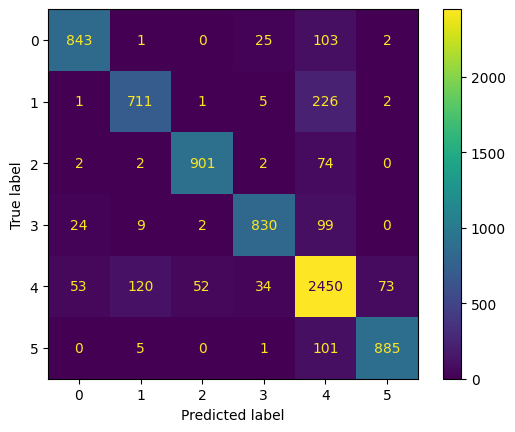

Accuracy:  0.8666055766461579
Precision:  0.8698034399927502
Sensitivity:  0.8666055766461579


In [11]:
from sklearn.model_selection import RandomizedSearchCV # Assuming you use KFold
def training_and_testing_svm(estimator, param_grid, X_train, y_train, X_test, y_test):
    grid_search = RandomizedSearchCV(estimator=estimator, param_distributions=param_grid, cv=kf, scoring='accuracy', verbose=3, n_iter=50)  # n_iter can be adjusted based on the number of combinations you want to try

    # Perform the grid search
    grid_search.fit(X_train, y_train)

    # Best parameters and best score
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # Calculate and print all final metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    sensitivity = recall_score(y_test, y_pred, average='weighted') # Sensitivity is the same as recall

    print(f"Final Test Accuracy: {accuracy:.2f}")
    print(f"Final Test Precision: {precision:.2f}")
    print(f"Final Test Sensitivity (Recall): {sensitivity:.2f}")

    # Display the final confusion matrix
    print("\nFinal Confusion Matrix (on test data):")
    mat_con = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=mat_con)
    disp.plot()
    plt.show()
    return accuracy, precision, sensitivity, grid_search

from sklearn.svm import SVC
from sklearn.datasets import make_classification # Import make_classification
from sklearn.model_selection import train_test_split # Import train_test_split

from sklearn.svm import SVC
# Define the model and parameters to tune
svm = SVC()
param_grid = [
    {'kernel': ['rbf'], 'C': [0.1, 1, 10, 100], 'gamma': ['scale', 1, 0.1, 0.01]},
    #{'kernel': ['linear'], 'C': [0.1, 1, 10, 100]}
]

accuracy, precision, sensitivity, grid_search = training_and_testing_svm(svm, param_grid, X_train, y_train, X_test, y_test)
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Sensitivity: ", sensitivity)
average = np.vstack((average,accuracy))
preci=np.vstack((preci,precision))
senci=np.vstack((senci,sensitivity))
bst_est.append(grid_search.best_params_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END .........................shrinkage=None, solver=svd; total time=   0.1s
[CV] END .........................shrinkage=None, solver=svd; total time=   0.0s
[CV] END .........................shrinkage=None, solver=svd; total time=   0.0s
[CV] END .........................shrinkage=None, solver=svd; total time=   0.0s
[CV] END .........................shrinkage=None, solver=svd; total time=   0.0s
[CV] END ........................shrinkage=None, solver=lsqr; total time=   0.0s
[CV] END ........................shrinkage=None, solver=lsqr; total time=   0.0s
[CV] END ........................shrinkage=None, solver=lsqr; total time=   0.0s
[CV] END ........................shrinkage=None, solver=lsqr; total time=   0.0s
[CV] END ........................shrinkage=None, solver=lsqr; total time=   0.0s
[CV] END .......................shrinkage=None, solver=eigen; total time=   0.0s
[CV] END .......................shrinkage=None, 

c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
20 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\

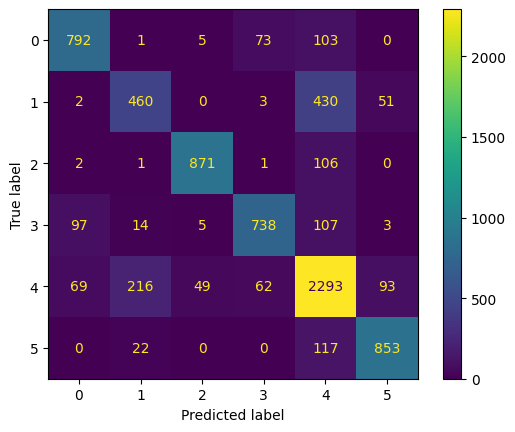

Accuracy:  0.7863594711349653
Precision:  0.7865909144907882
Sensitivity:  0.7863594711349653


In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
param_grid = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'shrinkage': [None, 'auto', 0.1, 0.5, 0.9]
}

accuracy, precision, sensitivity, grid_search = training_and_testing(lda, param_grid, X_train, y_train, X_test, y_test)
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Sensitivity: ", sensitivity)
average = np.vstack((average,accuracy))
preci=np.vstack((preci,precision))
senci=np.vstack((senci,sensitivity))
bst_est.append(grid_search.best_params_)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV] END activation=tanh  , alpha=0.0001, hidden_layer_sizes=(50,), solver=adam; total time=   0.0s
[CV] END activation=tanh  , alpha=0.0001, hidden_layer_sizes=(50,), solver=adam; total time=   0.0s
[CV] END activation=tanh  , alpha=0.0001, hidden_layer_sizes=(50,), solver=adam; total time=   0.0s
[CV] END activation=tanh  , alpha=0.0001, hidden_layer_sizes=(50,), solver=adam; total time=   0.0s
[CV] END activation=tanh  , alpha=0.0001, hidden_layer_sizes=(50,), solver=adam; total time=   0.0s
[CV] END activation=tanh  , alpha=0.0001, hidden_layer_sizes=(50,), solver=sgd; total time=   0.0s
[CV] END activation=tanh  , alpha=0.0001, hidden_layer_sizes=(50,), solver=sgd; total time=   0.0s
[CV] END activation=tanh  , alpha=0.0001, hidden_layer_sizes=(50,), solver=sgd; total time=   0.0s
[CV] END activation=tanh  , alpha=0.0001, hidden_layer_sizes=(50,), solver=sgd; total time=   0.0s
[CV] END activation=tanh  , alpha=0.0001, 

c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
200 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1358, in wrapper
    estimator._validate_params()
  File "c:\Users\GT-One! 2\AppData\Local\Programs\Python\Python311\Lib\site-packa

Best parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100, 50), 'solver': 'adam'}
Best cross-validation score: 0.93
Final Test Accuracy: 0.95
Final Test Precision: 0.95
Final Test Sensitivity (Recall): 0.95

Final Confusion Matrix (on test data):


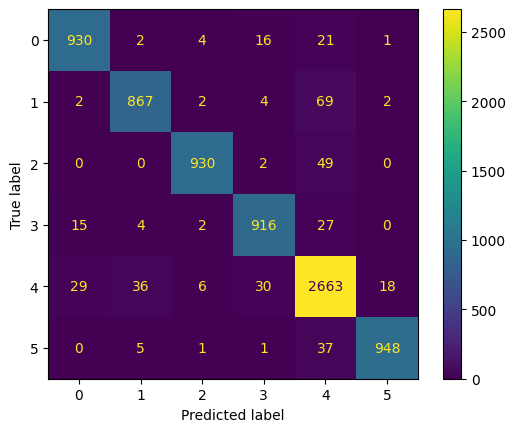

Accuracy:  0.9496007330802461
Precision:  0.9500722739962568
Sensitivity:  0.9496007330802461


In [13]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(max_iter=1000)  # Increased max_iter for better convergence
param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
              'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
              'activation': ['tanh  ', 'relu'],
              'solver': ['adam', 'sgd']}

accuracy, precision, sensitivity, grid_search = training_and_testing(mlp, param_grid, X_train, y_train, X_test, y_test)
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Sensitivity: ", sensitivity)
average = np.vstack((average,accuracy))
preci=np.vstack((preci,precision))
senci=np.vstack((senci,sensitivity))
bst_est.append(grid_search.best_params_)

In [ ]:
# prompt: take  average preci and sensci  and consider this, rows are porcentages so must be *100 and it must be first column value +/- second column value, storage them as csv
import pandas as pd
def create_df(average, preci, senci, bst_est):
    # Convert numpy arrays to DataFrames
    average_df = pd.DataFrame(average, columns=['Accuracy'])
    preci_df = pd.DataFrame(preci, columns=['Precision'])
    senci_df = pd.DataFrame(senci, columns=['Sensitivity'])

    # Multiply the columns by 100 for percentage
    average_df[['Accuracy']] *= 100
    preci_df[['Precision']] *= 100
    senci_df[['Sensitivity']] *= 100

    # Combine mean and std columns into a single string format for each metric
    average_df['Accuracy'] = average_df['Accuracy'].round(2).astype(str) 
    preci_df['Precision'] = preci_df['Precision'].round(2).astype(str)
    senci_df['Sensitivity'] = senci_df['Sensitivity'].round(2).astype(str)

    results_df = pd.DataFrame({
    'Model': ['KNN', 'GaussianNB', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM', 'LDA', 'MLP'],
    'Accuracy': average_df['Accuracy'].iloc[1:].values,
    'Precision': preci_df['Precision'].iloc[1:].values,
    'Sensitivity': senci_df['Sensitivity'].iloc[1:].values,
    'Best Estimator Params': bst_est
    })
    return results_df

results_df = create_df(average, preci, senci, bst_est)
# Save the results to a CSV file
results_df.to_csv('model_performance_summary_force_hybrid.csv', index=False)

print("\nModel Performance Summary:")
results_df




Model Performance Summary:


,Model,Accuracy,Precision,Sensitivity,Best Estimator Params
0,KNN,98.32,98.35,98.32,"{'metric': 'manhattan', 'n_neighbors': 2}"
1,GaussianNB,74.39,74.62,74.39,{'var_smoothing': 6.579332246575682e-09}
2,Logistic Regression,82.05,82.28,82.05,"{'C': 0.03359818286283781, 'penalty': 'l2'}"
3,Decision Tree,88.55,88.6,88.55,"{'max_depth': 20, 'min_samples_leaf': 2, 'min_..."
4,Random Forest,93.73,93.98,93.73,"{'max_depth': 20, 'min_samples_leaf': 2, 'min_..."
5,SVM,86.66,86.98,86.66,"{'kernel': 'rbf', 'gamma': 'scale', 'C': 100}"
6,LDA,78.64,78.66,78.64,"{'shrinkage': None, 'solver': 'svd'}"
7,MLP,94.96,95.01,94.96,"{'activation': 'relu', 'alpha': 0.001, 'hidden..."
